# Using the LASSO and CV

This example is taken from a course assignment given in A2021.
By Simon Van Norden and Nicolas Harvie
***

> The data file `PSet1A2021.xlsx` contains monthly data for the period 1926-2020 for the variables

> **RETDVW**
: the total monthly return on the CRSP Value-weighted Index.
<br>
**CAPE**
: Robert Shiller's Cyclically-Adjusted Price/Earnings ratio
<br> **GS10**
: Yield on long-term US Govt bonds (%)
<br> 
**Riskfree**
: the risk-free rate of return (%)
<br> **Inflation**
: the (annualized) rate of inflation.

> There's been concern in recent months that rising inflation could lead to higher interest rates, which in turn could be bad for the stock market. To assess the effect of inflation and interest rates on market returns, you want to estimate 
$$
RETDW_t = \beta_0 + \beta_{Infl} \cdot Inflation_t + \beta_{R_f} \cdot Riskfree_t + \beta_{Rlong} \cdot GS10_t + \beta_{PE} \cdot CAPE_t + e_t
$$
To limit the possible extent of overfitting, you decide to use the LASSO to estimate the relationship.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
Image(url="../slide_images/Overfitting.png", width=700, height=500)

              RETDVW       CAPE  GS10  Riskfree  Inflation
Date                                                      
1926-01-30 -0.001783  11.147365  3.68     3.357   0.000000
1926-02-27 -0.033296  11.340966  3.65     3.134   0.000000
1926-03-31 -0.057708  11.389436  3.62     3.122  -0.065022
1926-04-30  0.038522  10.712352  3.60     3.094   0.069539
1926-05-28  0.013623  10.395588  3.57     3.229  -0.065022
...              ...        ...   ...       ...        ...
2020-08-31  0.072068  29.599195  0.65     0.101   0.038499
2020-09-30 -0.038151  31.158209  0.68     0.086   0.016845
2020-10-30 -0.026409  30.839426  0.79     0.089   0.004991
2020-11-30  0.109403  31.283694  0.87     0.079  -0.007307
2020-12-31  0.041573  32.473204  0.93     0.079   0.011351

[1140 rows x 5 columns]


<AxesSubplot: xlabel='Date'>

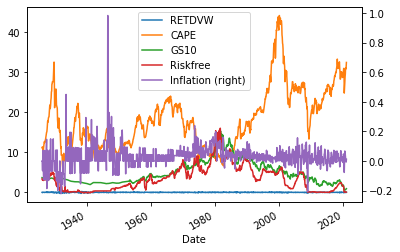

In [3]:
# Let's read the data 
Infl_data = pd.read_excel('../data/PSet1A2021.xlsx',index_col=0)
print(Infl_data)
# Let's standardize the data and plot it
fg1 = Infl_data.plot.line(secondary_y=['Inflation'])
fg1

> ### Part A
In a graph, show how the estimated coefficients of the independent variables change as you increase $\lambda$ from 0 to **XX**.

In [4]:
Image(url="../slide_images/LASSO.png", width=700, height=500)

Computing regularization path using the lasso...


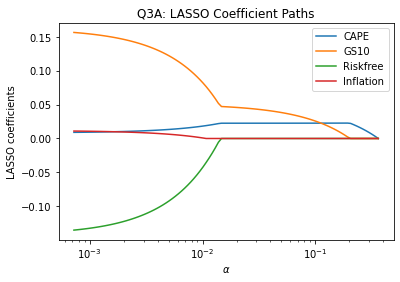

In [5]:
# Now let's answer the question from part A. 
from sklearn.linear_model import lasso_path
import matplotlib.pyplot as plt
%matplotlib inline

My_eps = 2e-3  # the smaller it is the longer is the path
Infl_data /= Infl_data.std(axis=0) # Standardize our series to have unit variance

print("Computing regularization path using the lasso...")
My_y = Infl_data.RETDVW
My_X = Infl_data.loc[:,"CAPE":"Inflation"]
alphas_lasso, coefs_lasso, _ = lasso_path(My_X, My_y, eps=My_eps)

#neg_log_alphas_lasso = -np.log10(alphas_lasso)
#pltQ3A = plt.plot(neg_log_alphas_lasso, coefs_lasso.T)
pltQ3A = plt.semilogx(alphas_lasso, coefs_lasso.T)
pltQ3A = plt.xlabel(r"$\alpha$")
pltQ3A = plt.ylabel('LASSO coefficients')
pltQ3A = plt.title('Q3A: LASSO Coefficient Paths')
pltQ3A = plt.legend(Infl_data.columns[1:5])
pltQ3A = plt.axis('tight')


> ### Part B
Use LOOCV to choose the appropriate value of $\lambda$. Report your estimated coefficients in a table. Which ones appear to be statistcally significant?<br>
Now select $\lambda$ using 5-fold CV and report the estimated coefficients. Does it make much difference?

Let's do the 5-fold CV first.

If you looked around in scikit learn, you probably found [this page](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py) which shows several of the tools for model selection, including [**LassoCV()**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV).

In [6]:
Image(url="../slide_images/CV.png", width=700, height=500)

In [7]:
from sklearn.linear_model import LassoCV

# Estimate the model with 5-fold CV
Q3B_model = LassoCV(  eps=My_eps, cv=5).fit(My_X, My_y)
# Output the results
print(f'The value of alpha that minimizes the MSE is {Q3B_model.alpha_:.5f}.')
print(f'The estimated coefficients selected by 5-fold CV are:')
Q3B_coef = pd.DataFrame(Q3B_model.coef_.T,index=My_X.columns,columns=['5-fold'])
print(Q3B_coef)


The value of alpha that minimizes the MSE is 0.05769.
The estimated coefficients selected by 5-fold CV are:
             5-fold
CAPE      -0.011965
GS10      -0.000000
Riskfree  -0.000000
Inflation -0.000000


Note that the LASSO only keeps one of the four indep variables in the model. It finds no useful role for interest rates or inflation rates. 

Now let's try the LOOCV. We could pass the [LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) function in scikit learn to the *cv=* parameter in LassoCV(). But a simpler trick is to set the number of folds equal to the number of data points.

In [8]:
# Estimate the model with LOOCV
# eps: Length of the path. eps=1e-3 means that alpha_min / alpha_max = 1e-3.
Q3B2_model = LassoCV(  eps=My_eps, cv=My_X.shape[0]).fit(My_X, My_y)
# Output the results
print(f'The value of alpha that minimizes the MSE is {Q3B2_model.alpha_:.5f}.')
print(f'The estimated coefficients selected by LOOCV are:')
Q3B_coef['LOOCV'] = Q3B2_model.coef_.T
print(Q3B_coef)

The value of alpha that minimizes the MSE is 0.02551.
The estimated coefficients selected by LOOCV are:
             5-fold     LOOCV
CAPE      -0.011965 -0.044174
GS10      -0.000000 -0.000000
Riskfree  -0.000000 -0.000000
Inflation -0.000000 -0.000000


Comparing the results, we see that both CV methods choose to keep only the CAPE variable. However, LOOCV chooses a value of $\alpha$ that is slightly less than half that choosen by 5-fold CV, and as a result chooses a larger (in absolute value) regression coefficient.


> ### Part C
Which set of estimated coefficients from Part (B) do you think are the most reliable? Explain.

Theory tells us that the LOOCV will give a less biased estimate of model performance, but that its estimate will be subject to more uncertainty because bias-variance tradeoff. We'd therefore expect the 5-fold to give more reliable coefficient estimates. 

To better understand how much uncertainty there is about the model's performance, we can compare the MSE's from LOOCV to those from each fold of the 5-fold CV.



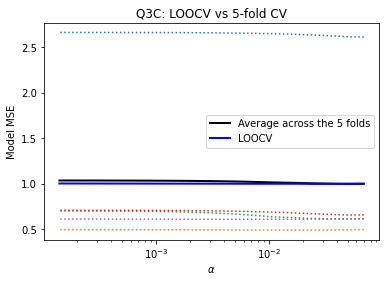

In [9]:
plt.figure()
plt.title('Q3C: LOOCV vs 5-fold CV')
plt.xlabel(r"$\alpha$")
plt.ylabel('Model MSE')
# plot each fold of the 5-fold CV as dotted lines
plt.semilogx(Q3B_model.alphas_, Q3B_model.mse_path_,":")
# Add the average of the 5 folds
plt.plot(Q3B_model.alphas_, Q3B_model.mse_path_.mean(axis=-1),"k",
    label="Average across the 5 folds",linewidth=2 )
# now add the LOOCV as a solid line
plt.plot(Q3B2_model.alphas_, Q3B2_model.mse_path_.mean(axis=-1),"b",
    label="LOOCV",linewidth=2 )
plt.legend()

The results for the 5-fold show that there is lots of variation in performance across the folds, implying that the relationship is quite unstable.

However, both methods provide similar estimates of the MSE, as we can see more clearly, below.

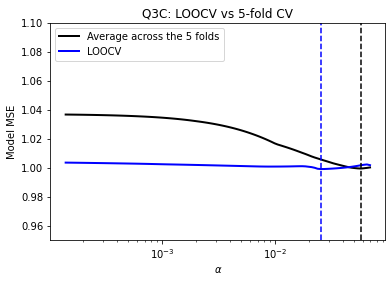

In [10]:
plt.figure()
plt.title('Q3C: LOOCV vs 5-fold CV')
plt.xlabel(r"$\alpha$")
plt.ylabel('Model MSE')
# plot each fold of the 5-fold CV as dotted lines
plt.ylim(0.95, 1.1)
plt.semilogx(Q3B_model.alphas_, Q3B_model.mse_path_,":")
# Add the average of the 5 folds
plt.plot(Q3B_model.alphas_, Q3B_model.mse_path_.mean(axis=-1),"k",
    label="Average across the 5 folds",linewidth=2 )
# now add the LOOCV as a solid line
plt.plot(Q3B2_model.alphas_, Q3B2_model.mse_path_.mean(axis=-1),"b",
    label="LOOCV",linewidth=2 )
plt.axvline(Q3B2_model.alpha_, linestyle="--", color="b")
plt.axvline(Q3B_model.alpha_, linestyle="--", color="k")
plt.legend()
